In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
sys.path.append('../code')
import dataframe_utilities as util

In [4]:
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials
from functools import partial

import seaborn as sns

# Get Data

In [5]:
df = pd.read_csv('../data/df_w_features.csv', low_memory=False)
df.shape

(24160, 599)

In [6]:
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

In [7]:
mask = pd.to_datetime(X['date'],unit='s')>=pd.to_datetime('20-08-2019') #last time model was run
new_len = mask.sum() + 300 #add 300 more records to include old validation data, but none of the training data

X_train = X[:-new_len]
y_train = y[:-new_len]
X_valid = X[-new_len:]
y_valid = y[-new_len:]

# Benchmark

In [8]:
import pickle
encoder, model = pickle.load(open('../data/encoder_model.pk','rb'))
encoder, model

(CatBoostEncoder(cols=['home_team_abbr', 'away_team_abbr', 'home_pitcher',
                       'away_pitcher', 'home_team_season', 'away_team_season'],
                 drop_invariant=False, handle_missing='value',
                 handle_unknown='value', random_state=13, return_df=True,
                 sigma=None, verbose=0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=None, colsample_bytree=0.65, gamma=0,
               learning_rate=0.3, max_delta_step=0, max_depth=26,
               min_child_weight=18.0, missing=nan, n_estimators=100, n_jobs=1,
               nthread=None, num_boost_round=100, objective='binary:logistic',
               random_state=13, reg_alpha=0.057490000000000006, reg_lambda=1,
               scale_pos_weight=1, seed=None, silent=True,
               subsample=0.6000000000000001, verbosity=None))

In [9]:
X_train = encoder.fit_transform(X_train, y_train)
X_valid = encoder.transform(X_valid)

In [10]:
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]

bench_acc = accuracy_score(y_valid, xgb_test_preds)
bench_roc = roc_auc_score(y_valid, xgb_test_preds)
print(f"benchmarks:\n- Accuracy: {bench_acc*100:.1f}%\n- ROC AUC: {bench_roc:.3f}")

benchmarks:
- Accuracy: 64.6%
- ROC AUC: 0.637


# XGB

## Tune

In [11]:
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.schedulers import PopulationBasedTraining

def XGBCallback(env):
    tune.track.log(**dict(env.evaluation_result_list))

In [12]:
def train_xgb(params):
    for i in range(10):
        params['max_depth'] = int(params['max_depth'])
        gbm = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13, n_jobs=-1)
        model = gbm.fit(X_train, y_train,
                        verbose=False,
                        eval_set = [[X_train, y_train],
                                  [X_valid, y_valid]],
                        early_stopping_rounds=15,
                        callbacks=[XGBCallback])
        xgb_test_preds = model.predict(X_valid)
        proba = model.predict_proba(X_valid)[:,1]

        #penalize low discrimination
        score = roc_auc_score(y_valid, xgb_test_preds)
        if max(proba)<.7 and min(proba)>.3: score -= 0.05

        tune.track.log(mean_accuracy=score, done=True)

In [13]:
num_threads = 6
config = {
    "verbosity": 0,
    "num_threads": num_threads,
    "objective": "binary:logistic",
    "eval_metric": ["auc", "logloss"],
}

from ray.tune.schedulers import ASHAScheduler
space = {
    "max_depth": (10, 20),
    "min_child_weight": (2, 10),
    "learning_rate": (0.01,0.1),
    "subsample":(0.1,1),
    "colsample_bytree":(0.1,1),
    "reg_alpha": (1e-2, 1e2),
    "gamma": (1e-8, 1.0),
}

algo = BayesOptSearch(
    space,
    max_concurrent=2,
    metric="mean_accuracy",
    mode="max",
    utility_kwargs={
            "kind": "ucb",
            "kappa": 2.5,
            "xi": 0.0,
        },
)

results = tune.run(
    train_xgb,
    num_samples=500,
    search_alg=algo,
    scheduler=ASHAScheduler(metric="eval-logloss", mode="min"),
)

2019-08-27 21:24:23,712	WARNING worker.py:1438 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-08-27 21:24:23,714	INFO resource_spec.py:205 -- Starting Ray with 5.42 GiB memory available for workers and up to 2.72 GiB for objects. You can adjust these settings with ray.remote(memory=<bytes>, object_store_memory=<bytes>).
2019-08-27 21:24:24,247	INFO function_runner.py:254 -- tune.track signature detected.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 3.6/15.4 GiB



2019-08-27 21:24:26,067	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:24:26,068	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:24:26,178	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 3.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 2 ({'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child_weight=7.4818,reg_alpha=20.453,subsample=0.89031:	PENDING
RUNNING trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	RUNNING



2019-08-27 21:24:26,748	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:24:26,749	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:24:26,865	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


Result for train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child_weight=7.4818,reg_alpha=20.453,subsample=0.89031:
  date: 2019-08-27_21-24-49
  done: true
  experiment_id: 5861e6bc18eb4b7ba3577591dd4ba776
  hostname: system76-pc
  iterations_since_restore: 1
  mean_accuracy: 0.5434915977594024
  node_ip: 172.20.15.6
  pid: 31867
  time_since_restore: 21.16961431503296
  time_this_iter_s: 21.16961431503296
  time_total_s: 21.16961431503296
  timestamp: 1566966289
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: b7cb2642
  
== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 2 ({'RUNNING': 1, 'TERMINATED': 1})
RUNNING trials:
 - train_xgb_1_colsample_bytree=0.

2019-08-27 21:24:51,421	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:24:51,422	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:24:51,544	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


Result for train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:
  date: 2019-08-27_21-24-51
  done: true
  experiment_id: 7668837bd2a04f9c8076d65c3485b28a
  hostname: system76-pc
  iterations_since_restore: 1
  mean_accuracy: 0.5481298716694821
  node_ip: 172.20.15.6
  pid: 31861
  time_since_restore: 23.55178999900818
  time_this_iter_s: 23.55178999900818
  time_total_s: 23.55178999900818
  timestamp: 1566966291
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: b7854cf8
  


2019-08-27 21:25:04,676	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:25:04,677	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:25:04,957	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:25:05,091	WARNING util.py:144 -- The `start_trial` operation took 0.9812397956848145 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 4 ({'TERMINATED': 2, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_3_colsample_bytree=0.25365,gamma=0.72002,learning_rate=0.010085,max_depth=16.949,min_child_weight=7.508,reg_alpha=56.882,subsample=0.32669:	RUNNING
 - train_xgb_4_colsample_bytree=0.6014,gamma=0.20257,learning_rate=0.059189,max_depth=19.736,min_child_weight=9.8994,reg_alpha=0.62719,subsample=0.93539:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_ra

2019-08-27 21:25:22,978	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:25:22,979	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:25:23,285	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:25:23,441	WARNING util.py:144 -- The `start_trial` operation took 0.9375007152557373 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 5 ({'TERMINATED': 3, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_4_colsample_bytree=0.6014,gamma=0.20257,learning_rate=0.059189,max_depth=19.736,min_child_weight=9.8994,reg_alpha=0.62719,subsample=0.93539:	RUNNING
 - train_xgb_5_colsample_bytree=0.45631,gamma=0.82619,learning_rate=0.064658,max_depth=10.002,min_child_weight=2.2939,reg_alpha=99.642,subsample=0.49284:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_r

2019-08-27 21:25:45,092	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:25:45,092	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:25:45,201	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 6 ({'TERMINATED': 4, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_5_colsample_bytree=0.45631,gamma=0.82619,learning_rate=0.064658,max_depth=10.002,min_child_weight=2.2939,reg_alpha=99.642,subsample=0.49284:	RUNNING
 - train_xgb_6_colsample_bytree=0.78585,gamma=0.82361,learning_rate=0.063473,max_depth=10.421,min_child_weight=2.0022,reg_alpha=99.343,subsample=0.85325:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_r

2019-08-27 21:25:56,787	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:25:56,788	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:25:57,208	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:25:57,289	WARNING util.py:144 -- The `start_trial` operation took 1.0754690170288086 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 7 ({'TERMINATED': 5, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_6_colsample_bytree=0.78585,gamma=0.82361,learning_rate=0.063473,max_depth=10.421,min_child_weight=2.0022,reg_alpha=99.343,subsample=0.85325:	RUNNING
 - train_xgb_7_colsample_bytree=0.69789,gamma=0.64005,learning_rate=0.028933,max_depth=19.997,min_child_weight=2.0649,reg_alpha=98.846,subsample=0.12834:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_r

2019-08-27 21:26:25,031	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:26:25,032	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:26:25,148	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 8 ({'TERMINATED': 6, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_7_colsample_bytree=0.69789,gamma=0.64005,learning_rate=0.028933,max_depth=19.997,min_child_weight=2.0649,reg_alpha=98.846,subsample=0.12834:	RUNNING
 - train_xgb_8_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=79.44,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_dep

2019-08-27 21:26:37,171	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:26:37,171	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:26:37,316	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 9 ({'TERMINATED': 7, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_8_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=79.44,subsample=0.1:	RUNNING
 - train_xgb_9_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.01,max_depth=10.0,min_child_weight=10.0,reg_alpha=100.0,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child

2019-08-27 21:26:50,250	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:26:50,251	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:26:50,368	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 10 ({'TERMINATED': 8, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_9_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.01,max_depth=10.0,min_child_weight=10.0,reg_alpha=100.0,subsample=0.1:	RUNNING
 - train_xgb_10_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=10.0,reg_alpha=100.0,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_chil

2019-08-27 21:27:03,488	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:27:03,489	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:27:03,627	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 11 ({'TERMINATED': 9, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_10_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=10.0,reg_alpha=100.0,subsample=0.1:	RUNNING
 - train_xgb_11_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=44.823,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_chil

2019-08-27 21:27:17,679	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:27:17,679	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:27:17,793	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:27:17,843	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 12 ({'TERMINATED': 10, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_11_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=44.823,subsample=0.1:	RUNNING
 - train_xgb_12_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=45.381,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_ch

2019-08-27 21:27:32,337	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:27:32,338	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:27:32,467	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 13 ({'TERMINATED': 11, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_12_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=45.381,subsample=0.1:	RUNNING
 - train_xgb_13_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=0.01,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child

2019-08-27 21:27:43,724	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:27:43,724	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:27:43,850	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 14 ({'TERMINATED': 12, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_13_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=0.01,subsample=0.1:	RUNNING
 - train_xgb_14_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=65.539,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child_w

2019-08-27 21:27:57,047	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:27:57,048	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:27:57,169	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 15 ({'TERMINATED': 13, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_14_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=65.539,subsample=0.1:	RUNNING
 - train_xgb_15_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=65.478,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child_

2019-08-27 21:28:09,821	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:28:09,822	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:28:09,936	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 16 ({'TERMINATED': 14, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_15_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=65.478,subsample=0.1:	RUNNING
 - train_xgb_16_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=53.245,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_chi

2019-08-27 21:28:27,338	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:28:27,339	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:28:27,469	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:28:27,531	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 17 ({'TERMINATED': 15, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_16_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=53.245,subsample=0.1:	RUNNING
 - train_xgb_17_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.026863,max_depth=10.0,min_child_weight=10.0,reg_alpha=52.088,subsample=1.0:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192

2019-08-27 21:28:55,468	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:28:55,469	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:28:55,893	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:28:56,057	WARNING util.py:144 -- The `start_trial` operation took 1.184753179550171 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 18 ({'TERMINATED': 16, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_17_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.026863,max_depth=10.0,min_child_weight=10.0,reg_alpha=52.088,subsample=1.0:	RUNNING
 - train_xgb_18_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=79.979,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,

2019-08-27 21:29:18,411	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:29:18,411	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:29:18,546	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 19 ({'TERMINATED': 17, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_18_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=79.979,subsample=0.1:	RUNNING
 - train_xgb_19_colsample_bytree=0.1,gamma=1.1505e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=80.066,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,m

2019-08-27 21:29:30,515	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:29:30,515	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:29:30,634	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 20 ({'TERMINATED': 18, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_19_colsample_bytree=0.1,gamma=1.1505e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=80.066,subsample=0.1:	RUNNING
 - train_xgb_20_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=47.669,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,m

2019-08-27 21:29:49,798	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:29:49,798	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:29:49,927	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 21 ({'TERMINATED': 19, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_20_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=47.669,subsample=0.1:	RUNNING
 - train_xgb_21_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=48.171,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_ch

2019-08-27 21:30:09,560	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:30:09,561	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:30:09,687	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:30:09,739	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 22 ({'TERMINATED': 20, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_21_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=48.171,subsample=0.1:	RUNNING
 - train_xgb_22_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=10.0,reg_alpha=14.179,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_chi

2019-08-27 21:30:23,601	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:30:23,602	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:30:23,745	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 23 ({'TERMINATED': 21, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_22_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=10.0,reg_alpha=14.179,subsample=0.1:	RUNNING
 - train_xgb_23_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=21.107,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child

2019-08-27 21:30:37,404	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:30:37,405	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:30:37,518	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 24 ({'TERMINATED': 22, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_23_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=21.107,subsample=0.1:	RUNNING
 - train_xgb_24_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=2.0,reg_alpha=23.219,subsample=1.0:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child

2019-08-27 21:30:56,672	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:30:56,672	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:30:56,796	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 25 ({'TERMINATED': 23, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_24_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=2.0,reg_alpha=23.219,subsample=1.0:	RUNNING
 - train_xgb_25_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=10.0,reg_alpha=34.02,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_chil

2019-08-27 21:31:10,137	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:31:10,138	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:31:10,260	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:31:10,317	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 26 ({'TERMINATED': 24, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_25_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=10.0,reg_alpha=34.02,subsample=0.1:	RUNNING
 - train_xgb_26_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=10.0,reg_alpha=35.502,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_chil

2019-08-27 21:31:23,202	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:31:23,203	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:31:23,328	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 27 ({'TERMINATED': 25, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_26_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=10.0,reg_alpha=35.502,subsample=0.1:	RUNNING
 - train_xgb_27_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child_w

2019-08-27 21:31:42,252	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:31:42,253	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:31:42,379	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 28 ({'TERMINATED': 26, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_27_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	RUNNING
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_child_weig

2019-08-27 21:32:02,724	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:32:02,724	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:32:02,867	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:32:02,926	ERROR trial_runner.py:552 -- Error processing event.
Traceback (most recent call last):
  File "/home/rdpharr/anaconda3/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 516, in _process_trial
    trial.trial_id, result=flat_result)
  File "/home/rdpharr/anaconda3/lib/python3.7/site-packages/ray/tune/suggest/bayesopt.py", line 108, in on_trial_complete
    target=self._metric_op * result[self._metric])
  File "/home/rdpharr/anaconda3/lib/python3.7/site-packages/bayes_opt/bayesian_optimi

== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 29 ({'TERMINATED': 27, 'RUNNING': 2})
RUNNING trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	RUNNING
 - train_xgb_29_colsample_bytree=0.1,gamma=1.0,learning_rate=0.092089,max_depth=20.0,min_child_weight=10.0,reg_alpha=74.736,subsample=0.1:	RUNNING
TERMINATED trials:
 - train_xgb_1_colsample_bytree=0.47532,gamma=0.72032,learning_rate=0.01001,max_depth=13.023,min_child_weight=3.174,reg_alpha=9.2429,subsample=0.26763:	TERMINATED, [1 CPUs, 0 GPUs], [pid=31861], 23 s, 0 iter, 0.548 acc
 - train_xgb_2_colsample_bytree=0.411,gamma=0.39677,learning_rate=0.058494,max_depth=14.192,min_ch

2019-08-27 21:32:14,081	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:32:14,082	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:32:14,201	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:32:14,259	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 30 ({'TERMINATED': 27, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_29_colsample_bytree=0.1,gamma=1.0,learning_rate=0.092089,max_depth=20.0,min_child_weight=10.0,reg_alpha=74.736,subsample=0.1:	RUNNING
 - train_xgb_30_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=20

2019-08-27 21:32:25,169	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:32:25,170	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:32:25,303	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 31 ({'TERMINATED': 28, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_30_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=20.0,min_child_weight=10.0,reg_alpha=78.241,subsample=0.1:	RUNNING
 - train_xgb_31_colsample_bytree=0.1,gamma=0.15503,learning_rate=0.1,max_depth=10.

2019-08-27 21:32:36,103	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:32:36,104	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:32:36,222	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 32 ({'TERMINATED': 29, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_31_colsample_bytree=0.1,gamma=0.15503,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=87.629,subsample=0.1:	RUNNING
 - train_xgb_32_colsample_bytree=0.80061,gamma=0.98568,learning_rate=0.062772,ma

2019-08-27 21:32:50,154	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:32:50,154	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:32:50,290	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 33 ({'TERMINATED': 30, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_32_colsample_bytree=0.80061,gamma=0.98568,learning_rate=0.062772,max_depth=10.085,min_child_weight=2.0524,reg_alpha=52.967,subsample=0.17389:	RUNNING
 - train_xgb_33_colsample_bytree=1.0,gamma=1e-08,learning_rate

2019-08-27 21:33:12,886	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:33:12,887	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:33:13,179	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:33:13,322	WARNING util.py:144 -- The `start_trial` operation took 1.0757169723510742 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 34 ({'TERMINATED': 31, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_33_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	RUNNING
 - train_xgb_34_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,mi

2019-08-27 21:33:33,125	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:33:33,125	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:33:33,289	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 35 ({'TERMINATED': 32, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_34_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=10.0,reg_alpha=48.277,subsample=0.16901:	RUNNING
 - train_xgb_35_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.01,max_depth

2019-08-27 21:33:46,604	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:33:46,605	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:33:46,723	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 36 ({'TERMINATED': 33, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_35_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.01,max_depth=20.0,min_child_weight=10.0,reg_alpha=48.849,subsample=0.1:	RUNNING
 - train_xgb_36_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.

2019-08-27 21:34:11,345	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:34:11,353	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:34:11,695	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:34:11,851	WARNING util.py:144 -- The `start_trial` operation took 0.9732568264007568 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 37 ({'TERMINATED': 34, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_36_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=11.654,subsample=1.0:	RUNNING
 - train_xgb_37_colsample_bytree=0.1,gamma=0.11424,learning_rate=0.1,max_depth=10

2019-08-27 21:34:30,960	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:34:30,961	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:34:31,080	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 38 ({'TERMINATED': 35, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_37_colsample_bytree=0.1,gamma=0.11424,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=65.641,subsample=0.1:	RUNNING
 - train_xgb_38_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10

2019-08-27 21:34:44,527	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:34:44,528	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:34:44,665	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 39 ({'TERMINATED': 36, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_38_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=64.791,subsample=1.0:	RUNNING
 - train_xgb_39_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=20.0

2019-08-27 21:35:12,868	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:35:12,875	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:35:13,317	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:35:13,428	WARNING util.py:144 -- The `start_trial` operation took 1.2963063716888428 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 40 ({'TERMINATED': 37, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_39_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=11.169,subsample=1.0:	RUNNING
 - train_xgb_40_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=20.0,

2019-08-27 21:37:19,336	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:37:19,337	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:37:19,460	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 41 ({'TERMINATED': 38, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_40_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=11.171,subsample=1.0:	RUNNING
 - train_xgb_41_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.09

2019-08-27 21:37:33,574	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:37:33,574	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:37:33,699	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 42 ({'TERMINATED': 39, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_41_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=19.095,min_child_weight=2.6906,reg_alpha=64.459,subsample=1.0:	RUNNING
 - train_xgb_42_colsample_bytree=0.1722,gamma=0.037304,learning_rate=0.036531

2019-08-27 21:37:49,057	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:37:49,058	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:37:49,194	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 43 ({'TERMINATED': 40, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_42_colsample_bytree=0.1722,gamma=0.037304,learning_rate=0.036531,max_depth=19.433,min_child_weight=2.2388,reg_alpha=63.496,subsample=0.7167:	RUNNING
 - train_xgb_43_colsample_bytree=0.1,gamma=1.0217e-08,learning_

2019-08-27 21:38:02,019	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:38:02,020	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:38:02,139	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:38:02,196	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 44 ({'TERMINATED': 41, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_43_colsample_bytree=0.1,gamma=1.0217e-08,learning_rate=0.1,max_depth=14.602,min_child_weight=5.4838,reg_alpha=47.98,subsample=0.1:	RUNNING
 - train_xgb_44_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_de

2019-08-27 21:38:17,870	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:38:17,870	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:38:18,014	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 45 ({'TERMINATED': 42, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_44_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=10.0,reg_alpha=23.505,subsample=1.0:	RUNNING
 - train_xgb_45_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0

2019-08-27 21:38:28,703	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:38:28,703	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:38:28,818	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 46 ({'TERMINATED': 43, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_45_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=10.0,reg_alpha=90.094,subsample=0.1:	RUNNING
 - train_xgb_46_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=13.884

2019-08-27 21:38:40,310	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:38:40,310	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:38:40,445	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 47 ({'TERMINATED': 44, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_46_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=13.884,min_child_weight=10.0,reg_alpha=90.493,subsample=0.1:	RUNNING
 - train_xgb_47_colsample_bytree=0.1901,gamma=0.90885,learning_rate=0.038281,max_

2019-08-27 21:38:53,165	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:38:53,165	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:38:53,279	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 48 ({'TERMINATED': 45, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_47_colsample_bytree=0.1901,gamma=0.90885,learning_rate=0.038281,max_depth=10.8,min_child_weight=9.8451,reg_alpha=88.802,subsample=0.20762:	RUNNING
 - train_xgb_48_colsample_bytree=0.1,gamma=0.0037354,learning_rat

2019-08-27 21:39:04,935	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:39:04,936	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:39:05,076	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:39:05,135	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 49 ({'TERMINATED': 46, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_48_colsample_bytree=0.1,gamma=0.0037354,learning_rate=0.085789,max_depth=10.0,min_child_weight=2.0,reg_alpha=16.888,subsample=0.1:	RUNNING
 - train_xgb_49_colsample_bytree=0.15329,gamma=0.98399,learning_rate=0.07

2019-08-27 21:39:23,637	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:39:23,637	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:39:23,770	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 50 ({'TERMINATED': 47, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_49_colsample_bytree=0.15329,gamma=0.98399,learning_rate=0.075432,max_depth=10.178,min_child_weight=2.0927,reg_alpha=17.09,subsample=0.98811:	RUNNING
 - train_xgb_50_colsample_bytree=0.1,gamma=1e-08,learning_rate=

2019-08-27 21:39:26,092	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:39:26,093	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:39:26,251	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


Result for train_xgb_50_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.1566,reg_alpha=36.948,subsample=1.0:
  date: 2019-08-27_21-39-39
  done: true
  experiment_id: 98f66c84b9f14db2863beeecb68152dc
  hostname: system76-pc
  iterations_since_restore: 1
  mean_accuracy: 0.5419208085118994
  node_ip: 172.20.15.6
  pid: 826
  time_since_restore: 13.676662921905518
  time_this_iter_s: 13.676662921905518
  time_total_s: 13.676662921905518
  timestamp: 1566967179
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: c3d8ea30
  
== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 51 ({'TERMINATED': 49, 'ERROR': 1, 'RUNNING': 1})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.

2019-08-27 21:40:04,857	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:40:04,859	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:40:05,268	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:40:05,392	WARNING util.py:144 -- The `start_trial` operation took 1.3449645042419434 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 52 ({'TERMINATED': 49, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_51_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=12.029,subsample=1.0:	RUNNING
 - train_xgb_52_colsample_bytree=0.11405,gamma=0.00078538,learning_rate=0.06619,ma

2019-08-27 21:40:25,420	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:40:25,420	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:40:25,551	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 53 ({'TERMINATED': 50, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_52_colsample_bytree=0.11405,gamma=0.00078538,learning_rate=0.06619,max_depth=10.482,min_child_weight=5.0932,reg_alpha=57.773,subsample=0.14709:	RUNNING
 - train_xgb_53_colsample_bytree=0.1,gamma=1.0,learning_rate

2019-08-27 21:40:39,299	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:40:39,300	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:40:39,418	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 54 ({'TERMINATED': 51, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_53_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=24.822,subsample=0.1:	RUNNING
 - train_xgb_54_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min

2019-08-27 21:40:53,450	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:40:53,450	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:40:53,580	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 55 ({'TERMINATED': 52, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_54_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=24.881,subsample=0.1:	RUNNING
 - train_xgb_55_colsample_bytree=0.1,gamma=1.015e-08,learning_rate=0.1,max_depth=20

2019-08-27 21:41:08,137	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:41:08,138	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:41:08,276	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 56 ({'TERMINATED': 53, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_55_colsample_bytree=0.1,gamma=1.015e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=4.7616,subsample=0.1:	RUNNING
 - train_xgb_56_colsample_bytree=0.1,gamma=1.0476e-08,learning_rate=0.1,max_de

2019-08-27 21:41:25,187	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:41:25,187	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:41:25,322	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:41:25,393	WARNING ray_trial_executor.py:332 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 57 ({'TERMINATED': 54, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_56_colsample_bytree=0.1,gamma=1.0476e-08,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=6.411,subsample=0.1:	RUNNING
 - train_xgb_57_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=10.

2019-08-27 21:41:51,470	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:41:51,471	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:41:51,604	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 58 ({'TERMINATED': 55, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_57_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=77.829,subsample=1.0:	RUNNING
 - train_xgb_58_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min

2019-08-27 21:42:10,005	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:42:10,006	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:42:10,172	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 59 ({'TERMINATED': 56, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_58_colsample_bytree=0.1,gamma=1.0,learning_rate=0.01,max_depth=10.0,min_child_weight=2.0,reg_alpha=77.203,subsample=1.0:	RUNNING
 - train_xgb_59_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=19.333,

2019-08-27 21:42:35,574	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:42:35,580	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:42:35,864	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:42:36,014	WARNING util.py:144 -- The `start_trial` operation took 1.1906826496124268 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 60 ({'TERMINATED': 57, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_59_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=19.333,min_child_weight=9.6796,reg_alpha=6.4955,subsample=1.0:	RUNNING
 - train_xgb_60_colsample_bytree=0.96512,gamma=1.0,learning_rate=0.1,max_depth

2019-08-27 21:43:18,170	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:43:18,171	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:43:18,306	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 61 ({'TERMINATED': 58, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_59_colsample_bytree=1.0,gamma=1.0,learning_rate=0.01,max_depth=19.333,min_child_weight=9.6796,reg_alpha=6.4955,subsample=1.0:	RUNNING
 - train_xgb_61_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.

2019-08-27 21:43:43,281	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:43:43,282	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:43:43,706	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:43:43,822	WARNING util.py:144 -- The `start_trial` operation took 1.068873405456543 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.9/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 62 ({'TERMINATED': 59, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_61_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=9.8566,reg_alpha=8.1323,subsample=1.0:	RUNNING
 - train_xgb_62_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.086454,max_depth

2019-08-27 21:44:31,439	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:44:31,439	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:44:31,563	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 4.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 63 ({'TERMINATED': 60, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_61_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=9.8566,reg_alpha=8.1323,subsample=1.0:	RUNNING
 - train_xgb_63_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.0,m

2019-08-27 21:44:55,333	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:44:55,336	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:44:55,632	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:44:55,765	WARNING util.py:144 -- The `start_trial` operation took 1.086134910583496 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 64 ({'TERMINATED': 61, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_63_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=88.681,subsample=1.0:	RUNNING
 - train_xgb_64_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_

2019-08-27 21:45:50,936	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:45:50,936	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:45:51,069	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.0/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 65 ({'TERMINATED': 62, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_64_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=29.195,subsample=0.1:	RUNNING
 - train_xgb_65_colsample_bytree=0.9104,gamma=1.0,learning_rate=0.014358,max_depth=1

2019-08-27 21:46:07,617	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:46:07,618	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:46:07,740	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.2/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 66 ({'TERMINATED': 63, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_65_colsample_bytree=0.9104,gamma=1.0,learning_rate=0.014358,max_depth=10.0,min_child_weight=9.7131,reg_alpha=17.041,subsample=0.1:	RUNNING
 - train_xgb_66_colsample_bytree=0.74376,gamma=0.90651,learning_rate=0.05

2019-08-27 21:46:24,926	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:46:24,926	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:46:25,066	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 67 ({'TERMINATED': 64, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_66_colsample_bytree=0.74376,gamma=0.90651,learning_rate=0.058308,max_depth=10.028,min_child_weight=6.9471,reg_alpha=20.427,subsample=0.10965:	RUNNING
 - train_xgb_67_colsample_bytree=1.0,gamma=1e-08,learning_rate

2019-08-27 21:46:45,339	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:46:45,340	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:46:45,801	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:46:45,956	WARNING util.py:144 -- The `start_trial` operation took 1.5035879611968994 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 68 ({'TERMINATED': 65, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_67_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.082713,max_depth=15.649,min_child_weight=5.8854,reg_alpha=81.878,subsample=1.0:	RUNNING
 - train_xgb_68_colsample_bytree=0.12674,gamma=0.99899,learning_rate=0.0

2019-08-27 21:47:16,860	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:47:16,861	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:47:16,990	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.1/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 69 ({'TERMINATED': 66, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_67_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.082713,max_depth=15.649,min_child_weight=5.8854,reg_alpha=81.878,subsample=1.0:	RUNNING
 - train_xgb_69_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.045397,

2019-08-27 21:47:41,197	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:47:41,208	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:47:41,458	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:47:41,626	WARNING util.py:144 -- The `start_trial` operation took 1.136075496673584 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 70 ({'TERMINATED': 67, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_69_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.045397,max_depth=15.154,min_child_weight=6.3621,reg_alpha=80.728,subsample=1.0:	RUNNING
 - train_xgb_70_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_dep

2019-08-27 21:48:08,017	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:48:08,018	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:48:08,153	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 71 ({'TERMINATED': 68, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_70_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=15.937,min_child_weight=2.0,reg_alpha=72.874,subsample=0.1:	RUNNING
 - train_xgb_71_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=10.0,mi

2019-08-27 21:48:27,315	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:48:27,317	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:48:27,586	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:48:27,684	WARNING util.py:144 -- The `start_trial` operation took 0.9861886501312256 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 72 ({'TERMINATED': 69, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_71_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=2.0,reg_alpha=6.6476,subsample=1.0:	RUNNING
 - train_xgb_72_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_

2019-08-27 21:49:02,226	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:49:02,227	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:49:02,369	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 73 ({'TERMINATED': 70, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_72_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=6.3232,reg_alpha=43.747,subsample=1.0:	RUNNING
 - train_xgb_73_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.0,m

2019-08-27 21:49:21,593	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:49:21,598	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:49:21,933	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:49:22,073	WARNING util.py:144 -- The `start_trial` operation took 1.1084742546081543 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.8/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 74 ({'TERMINATED': 71, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_73_colsample_bytree=1.0,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=3.4509,reg_alpha=7.6415,subsample=1.0:	RUNNING
 - train_xgb_74_colsample_bytree=0.95564,gamma=0.93325,learning_rate=0.096889,max

2019-08-27 21:50:59,833	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:50:59,833	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:50:59,976	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.3/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 75 ({'TERMINATED': 72, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_74_colsample_bytree=0.95564,gamma=0.93325,learning_rate=0.096889,max_depth=19.954,min_child_weight=2.133,reg_alpha=8.1679,subsample=0.77475:	RUNNING
 - train_xgb_75_colsample_bytree=1.0,gamma=1e-08,learning_rate=

2019-08-27 21:51:21,508	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:51:21,509	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:51:21,633	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 76 ({'TERMINATED': 73, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_75_colsample_bytree=1.0,gamma=1e-08,learning_rate=0.1,max_depth=19.159,min_child_weight=10.0,reg_alpha=42.289,subsample=0.1:	RUNNING
 - train_xgb_76_colsample_bytree=0.8701,gamma=0.040178,learning_rate=0.01793,ma

2019-08-27 21:51:41,616	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:51:41,617	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:51:41,912	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2019-08-27 21:51:42,005	WARNING util.py:144 -- The `start_trial` operation took 0.8673090934753418 seconds to complete, which may be a performance bottleneck.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.4/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 77 ({'TERMINATED': 74, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_76_colsample_bytree=0.8701,gamma=0.040178,learning_rate=0.01793,max_depth=14.686,min_child_weight=9.9688,reg_alpha=59.948,subsample=0.91652:	RUNNING
 - train_xgb_77_colsample_bytree=0.108,gamma=0.9752,learning_ra

2019-08-27 21:52:04,375	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:52:04,376	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:52:04,497	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.6/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 78 ({'TERMINATED': 75, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_77_colsample_bytree=0.108,gamma=0.9752,learning_rate=0.033493,max_depth=14.62,min_child_weight=9.8472,reg_alpha=61.168,subsample=0.7598:	RUNNING
 - train_xgb_78_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,ma

2019-08-27 21:52:15,751	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:52:15,751	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:52:15,893	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.5/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 79 ({'TERMINATED': 76, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_78_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=46.494,subsample=0.1:	RUNNING
 - train_xgb_79_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,m

2019-08-27 21:52:27,213	WARNING logger.py:164 -- Couldn't import TensorFlow - disabling TensorBoard logging.
2019-08-27 21:52:27,214	WARNING logger.py:255 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.
2019-08-27 21:52:27,335	ERROR worker.py:1791 -- Warning: The actor WrappedTrackFunc has size 115284748 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2/8 CPUs, 0/0 GPUs, 0.0/5.42 GiB heap, 0.0/1.86 GiB objects
Memory usage on this node: 5.7/15.4 GiB
Result logdir: /home/rdpharr/ray_results/train_xgb
Number of trials: 80 ({'TERMINATED': 77, 'ERROR': 1, 'RUNNING': 2})
ERROR trials:
 - train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0:	ERROR, 1 failures: /home/rdpharr/ray_results/train_xgb/train_xgb_28_colsample_bytree=0.1,gamma=1.0,learning_rate=0.1,max_depth=20.0,min_child_weight=2.0,reg_alpha=0.01,subsample=1.0_2019-08-27_21-31-42c7pkysfa/error_2019-08-27_21-32-02.txt
RUNNING trials:
 - train_xgb_79_colsample_bytree=0.1,gamma=1e-08,learning_rate=0.1,max_depth=10.0,min_child_weight=10.0,reg_alpha=46.284,subsample=0.1:	RUNNING
 - train_xgb_80_colsample_bytree=0.1,gamma=0.99183,learning_rate=0.1,max_depth=14

2019-08-27 21:52:34,834	ERROR import_thread.py:89 -- ImportThread: Connection closed by server.
2019-08-27 21:52:34,834	ERROR worker.py:1793 -- listen_error_messages_raylet: Connection closed by server.
2019-08-27 21:52:34,835	ERROR worker.py:1693 -- print_logs: Connection closed by server.


KeyboardInterrupt: 

In [17]:
# load results from disk
from ray.tune import Analysis
results = Analysis("~/ray_results/train_xgb")
results.dataframe()['mean_accuracy'].max()

0.645638837023206

In [18]:
xgb_params = results.get_best_config(metric="mean_accuracy")
xgb_params['max_depth']=int(xgb_params['max_depth'])
xgb_params

{'colsample_bytree': 1.0,
 'gamma': 1e-08,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 10.0,
 'reg_alpha': 25.2379554214079,
 'subsample': 0.10694933059531121}

## Greedy Hyperopt

In [30]:
xgb_params = {'colsample_bytree': 1.0,
 'gamma': 1e-08,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 10.0,
 'reg_alpha': 25.2379554214079,
 'subsample': 0.10694933059531121}

In [31]:
def xgb_objective(new_params, data):
    X_train,y_train,X_valid,y_valid, params = data
    
    if 'max_depth' in new_params.keys():
        new_params['max_depth']=int(new_params['max_depth'])
    if 'reg_alpha' in new_params.keys():
        new_params['reg_alpha']=np.exp(new_params['reg_alpha'])
    
    for x in new_params.keys():
        params[x] = new_params[x]
    
    np.random.seed(13)
    gbm = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13, n_jobs=-1)
    model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    xgb_test_preds = model.predict(X_valid)
    proba = model.predict_proba(X_valid)[:,1]
    
    #penalize low discrimination
    score = -roc_auc_score(y_valid, xgb_test_preds)
    if max(proba)<.7 and min(proba)>.3: score += 0.05
    
    return(score)

In [32]:
def get_xgbparams(space, full_params, evals=15):
    fmin_objective = partial(xgb_objective, data=(X_train,y_train,X_valid,y_valid,full_params))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=evals)
    
    #update full_params
    for x in full_params.keys():
        if x in params.keys():
            full_params[x]=params[x]
    full_params['max_depth']=int(full_params['max_depth'])
    if 'reg_alpha' in params.keys():
        full_params['reg_alpha']=np.exp(params['reg_alpha'])
    
    return full_params

In [33]:
space = {
    'max_depth':  hp.quniform('max_depth', 10, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 2, 10, 1),
    'learning_rate': hp.quniform('learning_rate', .01, .08, .01),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
    'reg_alpha': hp.quniform('reg_alpha', -2, 4,0.5),
}
xgb_params = get_xgbparams(space,xgb_params,10)

 40%|████      | 4/10 [02:56<04:50, 48.40s/it, best loss: -0.561244480009484] 


KeyboardInterrupt: 

In [26]:
xgb_params

{'colsample_bytree': 0.2,
 'learning_rate': 0.07,
 'max_depth': 16,
 'min_child_weight': 9.0,
 'reg_alpha': 12.182493960703473,
 'subsample': 0.4}

## Test

In [19]:
xgb_params

{'colsample_bytree': 1.0,
 'gamma': 1e-08,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 10.0,
 'reg_alpha': 25.2379554214079,
 'subsample': 0.10694933059531121}

In [20]:
gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100, random_state=13, n_jobs=-1)
model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

[0]	validation_0-error:0.490458	validation_1-error:0.467568
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 15 rounds.
[1]	validation_0-error:0.458806	validation_1-error:0.440541
[2]	validation_0-error:0.450021	validation_1-error:0.427027
[3]	validation_0-error:0.440437	validation_1-error:0.372973
[4]	validation_0-error:0.434594	validation_1-error:0.372973
[5]	validation_0-error:0.430055	validation_1-error:0.378378
[6]	validation_0-error:0.427112	validation_1-error:0.37027
[7]	validation_0-error:0.422068	validation_1-error:0.37027
[8]	validation_0-error:0.418327	validation_1-error:0.372973
[9]	validation_0-error:0.418579	validation_1-error:0.364865
[10]	validation_0-error:0.41509	validation_1-error:0.383784
[11]	validation_0-error:0.415679	validation_1-error:0.367568
[12]	validation_0-error:0.414334	validation_1-error:0.372973
[13]	validation_0-error:0.412064	validation_1-error:0.37297

(0.6567567567567567, 0.645638837023206)

In [21]:
print(f"new model ROC: {roc_auc_score(y_valid, xgb_test_preds):.3f}\nold model ROC: {bench_roc:.3f}\n")

new model ROC: 0.646
old model ROC: 0.637



In [ ]:
# import pickle
# pickle.dump((encoder, model), open('../data/encoder_model.pk','wb'))

## EDA

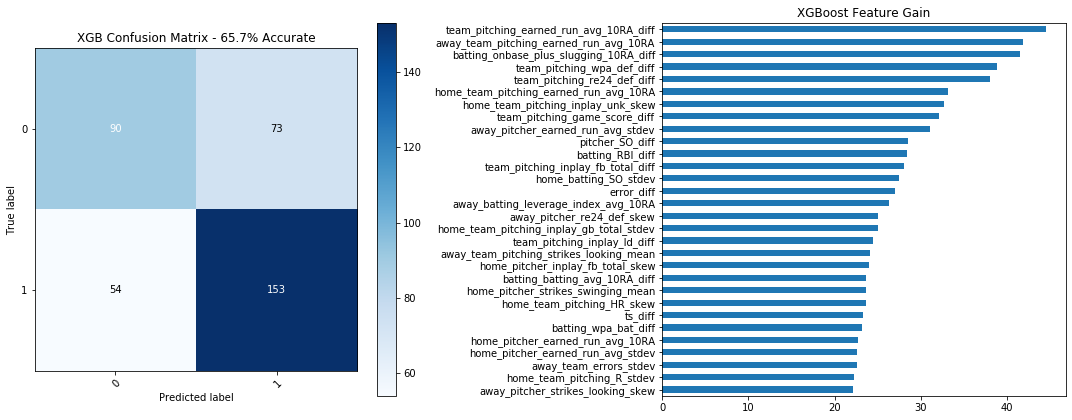

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-30:].plot(kind='barh',ax=ax[1], title="XGBoost Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], 
                           ax=ax[0], title = f"XGB Confusion Matrix - {accuracy_score(y_valid, xgb_test_preds)*100:.1f}% Accurate")

fig.tight_layout()

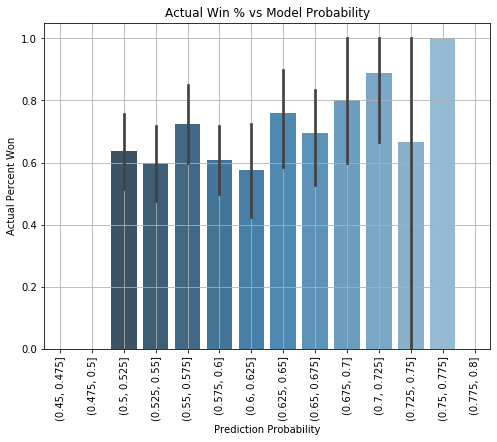

In [28]:
df = pd.DataFrame()
df['proba'] = xgb_test_proba
df['home_win'] = list(y_valid)
df['confidence'] = np.abs(df.proba-.5)+.5
df['bet_win'] = df['home_win']
df['bet_win'][df['proba']<.5] = -df['home_win']

bins=[x/40 for x in range(18,33)]
df['probability_bin'] = pd.cut(df['confidence'], bins)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=df['probability_bin'], y=df.bet_win,palette="Blues_d")
ax.set_title("Actual Win % vs Model Probability")
plt.ylabel("Actual Percent Won")
plt.xlabel("Prediction Probability")
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# df.groupby('probability_bin')['bet_win'].agg(['mean','count'])

In [30]:
print("win % for bets with greater than x confidence:")
for x in range(10,18):
    d = df.bet_win[df.confidence>=x/20]
    print(f" conf: {x/20:.2f}, win %:{d.mean()*100:.1f}%, % of total {d.count()*100/len(df):.1f}%")

win % for bets with greater than x confidence:
 conf: 0.50, win %:65.7%, % of total 100.0%
 conf: 0.55, win %:67.9%, % of total 64.1%
 conf: 0.60, win %:69.9%, % of total 35.9%
 conf: 0.65, win %:75.0%, % of total 17.3%
 conf: 0.70, win %:84.6%, % of total 3.5%
 conf: 0.75, win %:100.0%, % of total 0.3%
 conf: 0.80, win %:nan%, % of total 0.0%
 conf: 0.85, win %:nan%, % of total 0.0%


# Other Models

## LightGBM

In [ ]:
import lightgbm as lgbm

In [ ]:
lgbm_params = {'colsample_by_tree': 0.7,
 'learning_rate': 0.65,
 'max_depth': 8,
 'min_data_in_leaf': 500,
 'num_leaves': 204,
 'subsample': 0.6,
 'boosting_type': 'gbdt'}

In [ ]:
gbm = lgbm.LGBMClassifier(**lgbm_params,num_boost_round=100, random_state=-1)
model = gbm.fit(X_train, y_train,
                verbose=False,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = model.predict(X_valid)
lgbm_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

In [ ]:
def lgbm_objective(new_params, data):
    X_train,y_train,X_valid,y_valid, params = data
    
    if 'max_depth' in new_params.keys():
        new_params['max_depth']=int(new_params['max_depth'])
        params['num_leaves']=int(2**params['max_depth']*params['num_leaves'])
    if 'min_data_in_leaf' in new_params.keys():
        params['min_data_in_leaf']=int(params['min_data_in_leaf'])
    
    for x in new_params.keys():
        params[x] = new_params[x]
    
    np.random.seed(13)
    gbm = lgbm.LGBMClassifier(**params, num_boost_round=100, random_state=13)
    lgbm_model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    lgbm_test_preds = lgbm_model.predict(X_valid)
    
    proba = lgbm_model.predict_proba(X_valid)[:,1]
    
    #penalize low discrimination
    score = -roc_auc_score(y_valid, lgbm_test_preds)
    if max(proba)<.7 and min(proba)>.3: score += 0.05
    
    return score 
def get_lgbmparams(space, full_params, evals=15):
    fmin_objective = partial(xgb_objective, data=(X_train,y_train,X_valid,y_valid,full_params))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=evals)
    
    #update full_params
    for x in full_params.keys():
        if x in params.keys():
            full_params[x]=params[x]
    full_params['max_depth']=int(full_params['max_depth'])
    full_params['min_data_in_leaf']=int(full_params['min_data_in_leaf'])
    full_params['num_leaves']=int(2**full_params['max_depth']*full_params['num_leaves'])

    return full_params

In [ ]:
space = {
    'learning_rate': hp.quniform('learning_rate', .05, .8, .05),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'num_leaves': hp.quniform('num_leaves', 0.5, 1.0,.1),
#     'subsample': hp.quniform('subsample', 0.05, 1, .05),
#     'colsample_bytree': hp.quniform('colsample_by_tree', 0.05, 1.0,.05),
#     'min_data_in_leaf':hp.qloguniform('min_data_in_leaf', 5, 10, 100),
}
lgbm_params = get_lgbmparams(space,lgbm_params,25)

In [ ]:
space = {
#     'learning_rate': hp.quniform('learning_rate', .05, .8, .05),
#     'max_depth': hp.quniform('max_depth', 2, 10, 1),
#     'num_leaves': hp.quniform('num_leaves', 0.5, 1.0,.1),
    'subsample': hp.quniform('subsample', 0.1, 1, .1),
    'colsample_bytree': hp.quniform('colsample_by_tree', 0.1, 1.0,.1),
    'min_data_in_leaf':hp.qloguniform('min_data_in_leaf', 5, 10, 100),
}
lgbm_params = get_lgbmparams(space,lgbm_params,25)

In [ ]:
lgbm_params

In [ ]:
np.random.seed(13)
gbm = lgbm.LGBMClassifier(**lgbm_params, num_boost_round=100, random_state=13)
lgbm_model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = lgbm_model.predict(X_valid)
lgbm_test_proba = lgbm_model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

In [ ]:
print(f"new model ROC: {roc_auc_score(y_valid, lgbm_test_preds):.3f}\nold model ROC: {bench_roc:.3f}\n")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

lgbm_model.importance_type='gain'
l = pd.DataFrame(zip(X_train.columns,lgbm_model.feature_importances_), 
                 columns=['feature','value']).set_index('feature').sort_values(by='value')
l[-30:].plot(kind='barh',ax=ax[1],title="LightGBM Feature Gain")

util.plot_confusion_matrix(y_valid, lgbm_test_preds, [0,1], ax=ax[0],
                           title = f"LGBM Confusion Matrix - {accuracy_score(y_valid, lgbm_test_preds)*100:.1f}% Accurate")

fig.tight_layout()

In [ ]:
df = pd.DataFrame()
df['proba'] = lgbm_test_proba
df['home_win'] = list(y_valid)
df['confidence'] = np.abs(df.proba-.5)+.5
df['bet_win'] = df['home_win']
df['bet_win'][df['proba']<.5] = -df['home_win']

bins=[x/40 for x in range(19,30)]
df['probability_bin'] = pd.cut(df['confidence'], bins)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=df['probability_bin'], y=df.bet_win,palette="Blues_d")
ax.set_title("Actual Win % vs Model Probability")
plt.ylabel("Actual Percent Won")
plt.xlabel("Prediction Probability")
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# df.groupby('probability_bin')['bet_win'].agg(['mean','count'])

In [ ]:
print("win % for bets with greater than x confidence:")
for x in range(10,19):
    d = df.bet_win[df.confidence>x/20]
    print(f" conf: {x/20:.2f}, win %:{d.mean()*100:.1f}%, % of total {d.count()/6:.1f}%")

## Fastai

In [ ]:
from fastai import *
from fastai.tabular import *

In [ ]:
CAT_NAMES = [x for x in df.columns if df[x].dtype=='object']
CONT_NAMES = [x for x in df.columns if df[x].dtype not in ['object','bool']]

In [ ]:
data = (TabularList.from_df(df, path='.',                         
                        cat_names=CAT_NAMES,                        
                        cont_names=CONT_NAMES,                      
                        procs=[FillMissing, Categorify, Normalize]) 
        .split_by_idx(list(range(300)))                                        
        .label_from_df(cols='home_team_win')                                    
        .databunch())

In [ ]:
learn = tabular_learner(data, layers=[1000, 500], metrics=accuracy,          
                        ps=[.03, .3], wd=1e-1, emb_drop=.6)               

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(2, max_lr=1e-6) 

In [ ]:
preds, y = learn.get_preds(ds_type=DatasetType.Valid, with_loss=False)
preds = np.array(preds)[:,1]
accuracy_score(y, preds>0.5), roc_auc_score(y, preds>0.5)

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
import fastai
from fastprogress import force_console_behavior
import fastprogress

space = {'p2': hp.quniform('p2',0,.8,.1),
    'emb_drop': hp.quniform('emb_drop',0,.8,.1),
    'l1': hp.quniform('l1',500,1500,100),
         }

# suppress widgets
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar
fastprogress.fastprogress.WRITER_FN = str

def objective(x):
    #get params from hyperopt
    p2 = x['p2']
    p1 = p2/10
    emb_drop = x['emb_drop']
    l1=int(x['l1'])
    l2 = int(l1/2)
    # lr = x['lr']
    
    # freeze seeds
    import random
    import torch
    seed = 13
    random.seed(seed)    #python
    np.random.seed(seed) #numpy
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    # get to work
    learn = tabular_learner(data, layers=[l1,l2],ps=[p1,p2], wd=1e-1, emb_drop=emb_drop)
    learn.fit_one_cycle(2, max_lr=1e-2)
    preds, y = learn.get_preds(ds_type=DatasetType.Valid, with_loss=False)
    preds = np.array(preds)
    score = -roc_auc_score(y, preds[:,1]>0.5)
    
    return {'loss': score, 'status':'ok'}

trials = Trials()

best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)
best